# Iris Data Generation

# Index

1. [Libraries](#Libraries)
2. [Data Preparation](#Getting-Started)
3. [Exploring Architectures](#GAN-vs-VAE)
3. [Generating Syntethic Data](#Conditional-Generative-Adversarial-Network)
4. [Syntethic VS Real](#Quality-assessment)
5. [Conclusion](#Conclusion)

## Libraries

In [11]:
import sys
import os

import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, iqr, entropy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset, DataLoader

import torchmetrics

import random
from tqdm.auto import tqdm

Seed function for reproducibility.

In [2]:
def set_seed(seed = 0):
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [3]:
project_path = os.path.abspath("..")

if project_path not in sys.path:
    sys.path.append(project_path)

import utils

## Getting Started
The iris dataset will be used to validate the tabular data generation protocol, which despite its apparent simplicity may harbor pitfalls.

In [4]:
X, y = load_iris()['data'], load_iris()['target']
features, species = load_iris()['feature_names'], load_iris()['target_names']

real_iris = pd.DataFrame(X, columns = features)
real_iris['target'] = y
real_iris['target'] = real_iris['target'].map({i: species[i] for i in range(len(species))})
real_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Let's deep dive into our real data.

In [5]:
utils.describe_data(real_iris, 'target')

REAL                     
                       setosa versicolor virginica
MEAN sepal length (cm)  5.006      5.936     6.588
     sepal width (cm)   3.428      2.770     2.974
     petal length (cm)  1.462      4.260     5.552
     petal width (cm)   0.246      1.326     2.026
STD  sepal length (cm)  0.352      0.516     0.636
     sepal width (cm)   0.379      0.314     0.322
     petal length (cm)  0.174      0.470     0.552
     petal width (cm)   0.105      0.198     0.275
MIN  sepal length (cm)  4.300      4.900     4.900
     sepal width (cm)   2.300      2.000     2.200
     petal length (cm)  1.000      3.000     4.500
     petal width (cm)   0.100      1.000     1.400
MAX  sepal length (cm)  5.800      7.000     7.900
     sepal width (cm)   4.400      3.400     3.800
     petal length (cm)  1.900      5.100     6.900
     petal width (cm)   0.600      1.800     2.500
SKEW sepal length (cm)  0.116      0.102     0.114
     sepal width (cm)   0.040     -0.352     0.355
     petal length (cm)  0.103     -0.588     0.533
     petal width (cm)   1.216     -0.030    -0.126
KURT sepal length (cm) -0.346     -0.599    -0.088
     sepal width (cm)   0.744     -0.448     0.520
     petal length (cm)  0.805     -0.074    -0.256
     petal width (cm)   1.434     -0.488    -0.661
IQR  sepal length (cm)  0.400      0.700     0.675
     sepal width (cm)   0.475      0.475     0.375
     petal length (cm)  0.175      0.600     0.775
     petal width (cm)   0.100      0.300     0.500

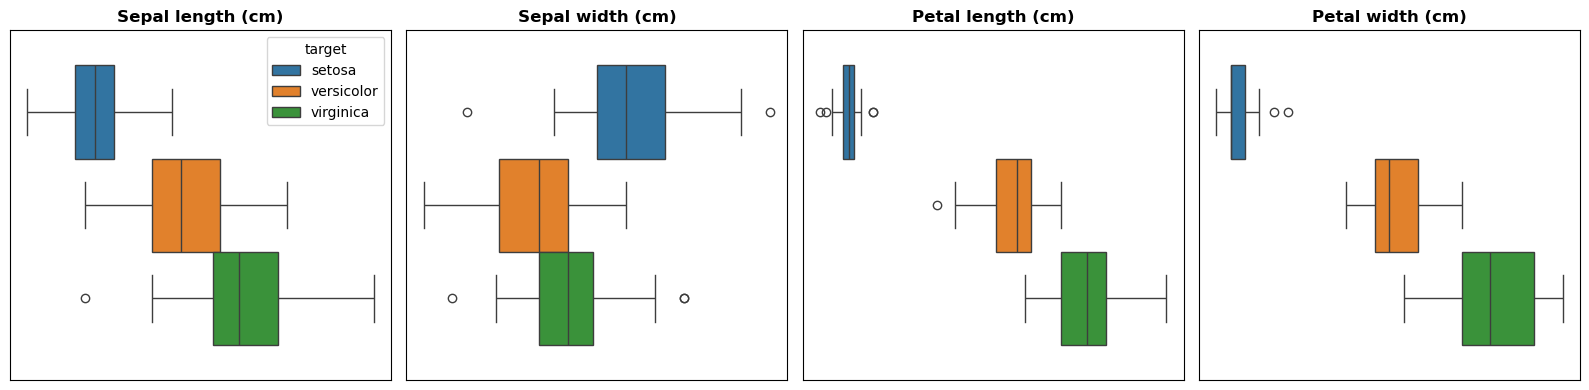

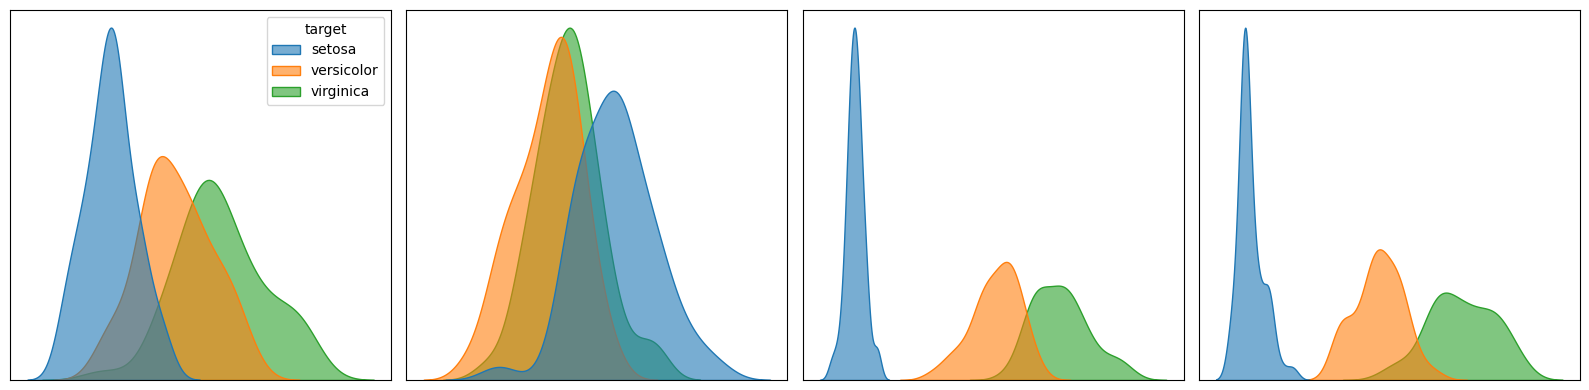

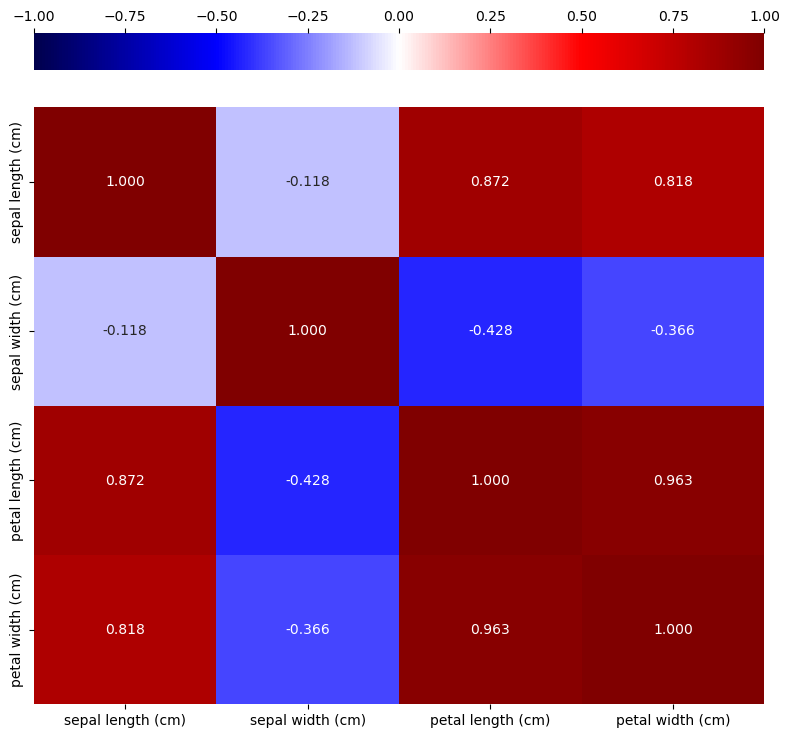

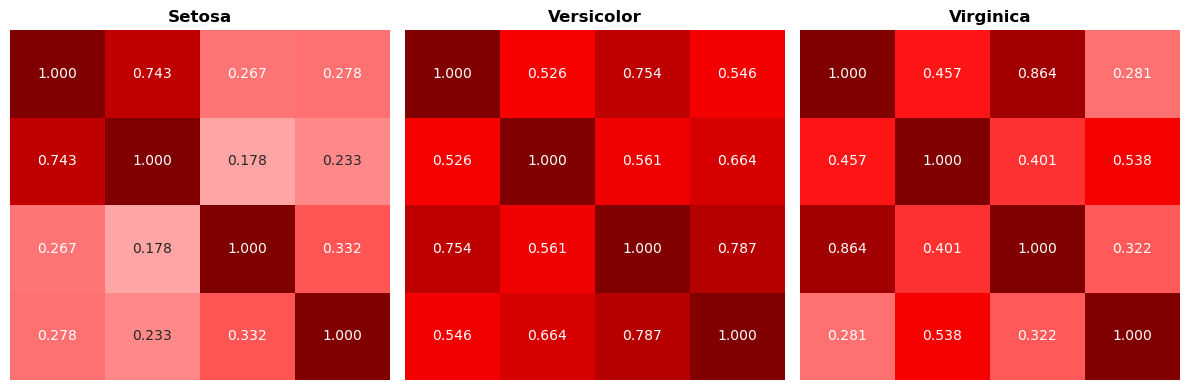

In [6]:
utils.plot_data(real_iris, 'target')

Throughout the notebook we will make comparisons between two datasets, one real and one synthetic; the following dataset, generated by adding normal noise to the real one, is used to introduce the comparison functions.

In [7]:
df = real_iris.select_dtypes('number') + np.random.normal(0, 1, (150,4))
df['target'] = real_iris['target']
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,6.160911,2.117753,4.013630,0.487498,setosa
1,3.945945,4.193741,1.689585,-0.567803,setosa
2,5.850015,3.138740,1.574303,-0.115068,setosa
3,4.506447,1.299759,1.952610,0.752327,setosa
4,4.933948,3.570367,1.737617,-0.477034,setosa


Let's start with comparisons! 

First of all a simply comparison between descriptives.

In [9]:
utils.describe_data(real_iris, 'target', df)

REAL                      SYNTHETIC             \
                       setosa versicolor virginica    setosa versicolor   
MEAN sepal length (cm)  5.006      5.936     6.588     4.825      5.975   
     sepal width (cm)   3.428      2.770     2.974     3.595      2.789   
     petal length (cm)  1.462      4.260     5.552     1.687      4.370   
     petal width (cm)   0.246      1.326     2.026    -0.148      1.477   
STD  sepal length (cm)  0.352      0.516     0.636     1.015      1.325   
     sepal width (cm)   0.379      0.314     0.322     1.156      0.998   
     petal length (cm)  0.174      0.470     0.552     1.243      1.077   
     petal width (cm)   0.105      0.198     0.275     0.807      0.987   
MIN  sepal length (cm)  4.300      4.900     4.900     2.707      1.888   
     sepal width (cm)   2.300      2.000     2.200     1.286      0.553   
     petal length (cm)  1.000      3.000     4.500    -0.751      1.636   
     petal width (cm)   0.100      1.000     1.400    -2.158     -0.992   
MAX  sepal length (cm)  5.800      7.000     7.900     7.080      8.368   
     sepal width (cm)   4.400      3.400     3.800     6.902      4.686   
     petal length (cm)  1.900      5.100     6.900     4.349      6.383   
     petal width (cm)   0.600      1.800     2.500     1.732      3.586   
SKEW sepal length (cm)  0.116      0.102     0.114     0.259     -0.799   
     sepal width (cm)   0.040     -0.352     0.355     0.232     -0.048   
     petal length (cm)  0.103     -0.588     0.533     0.304     -0.527   
     petal width (cm)   1.216     -0.030    -0.126    -0.036     -0.195   
KURT sepal length (cm) -0.346     -0.599    -0.088    -0.366      0.571   
     sepal width (cm)   0.744     -0.448     0.520     0.282     -0.610   
     petal length (cm)  0.805     -0.074    -0.256    -0.363      0.223   
     petal width (cm)   1.434     -0.488    -0.661     0.428     -0.236   
IQR  sepal length (cm)  0.400      0.700     0.675     1.323      1.627   
     sepal width (cm)   0.475      0.475     0.375     1.259      1.474   
     petal length (cm)  0.175      0.600     0.775     1.480      1.227   
     petal width (cm)   0.100      0.300     0.500     0.860      1.283   

                                  
                       virginica  
MEAN sepal length (cm)     6.564  
     sepal width (cm)      3.045  
     petal length (cm)     5.602  
     petal width (cm)      2.258  
STD  sepal length (cm)     1.505  
     sepal width (cm)      1.248  
     petal length (cm)     1.165  
     petal width (cm)      0.998  
MIN  sepal length (cm)     3.431  
     sepal width (cm)      0.124  
     petal length (cm)     3.629  
     petal width (cm)     -0.277  
MAX  sepal length (cm)    10.264  
     sepal width (cm)      5.717  
     petal length (cm)     8.677  
     petal width (cm)      4.871  
SKEW sepal length (cm)    -0.047  
     sepal width (cm)     -0.143  
     petal length (cm)     0.459  
     petal width (cm)      0.082  
KURT sepal length (cm)    -0.244  
     sepal width (cm)     -0.127  
     petal length (cm)    -0.518  
     petal width (cm)      0.323  
IQR  sepal length (cm)     1.886  
     sepal width (cm)      1.511  
     petal length (cm)     1.752  
     petal width (cm)      1.252

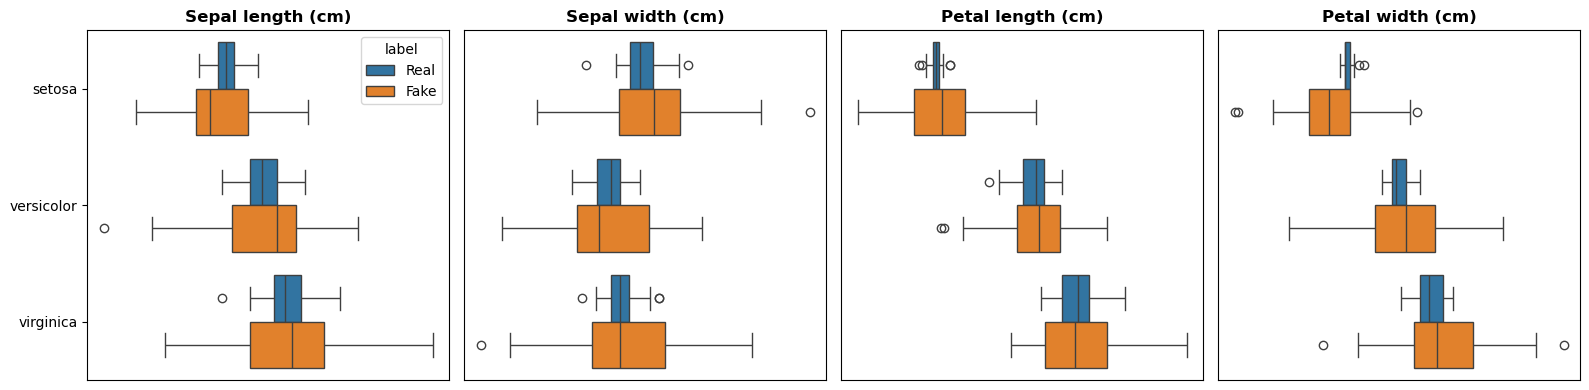

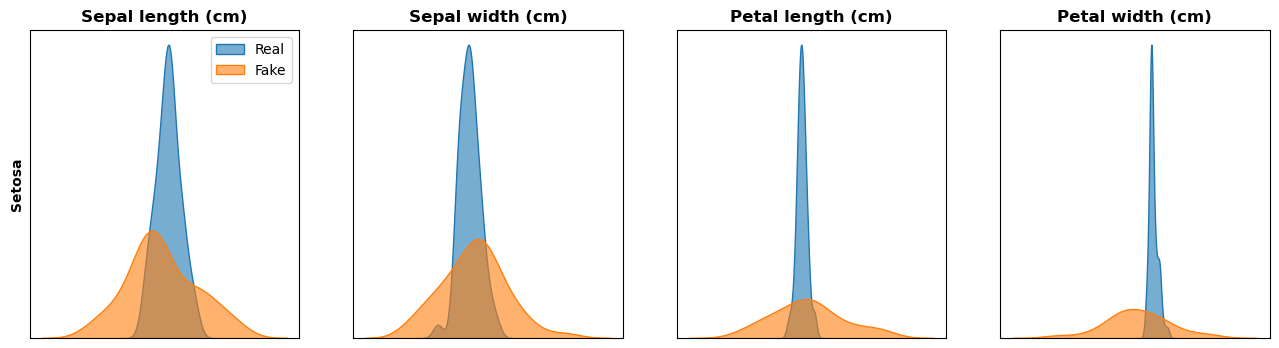

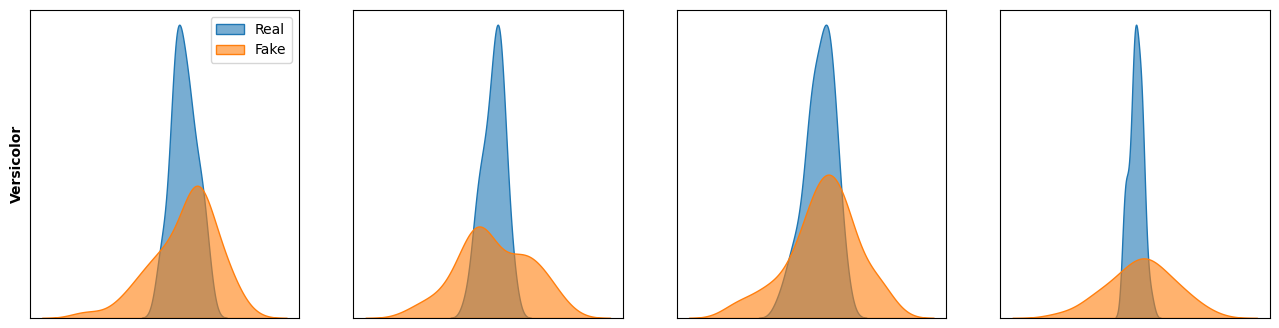

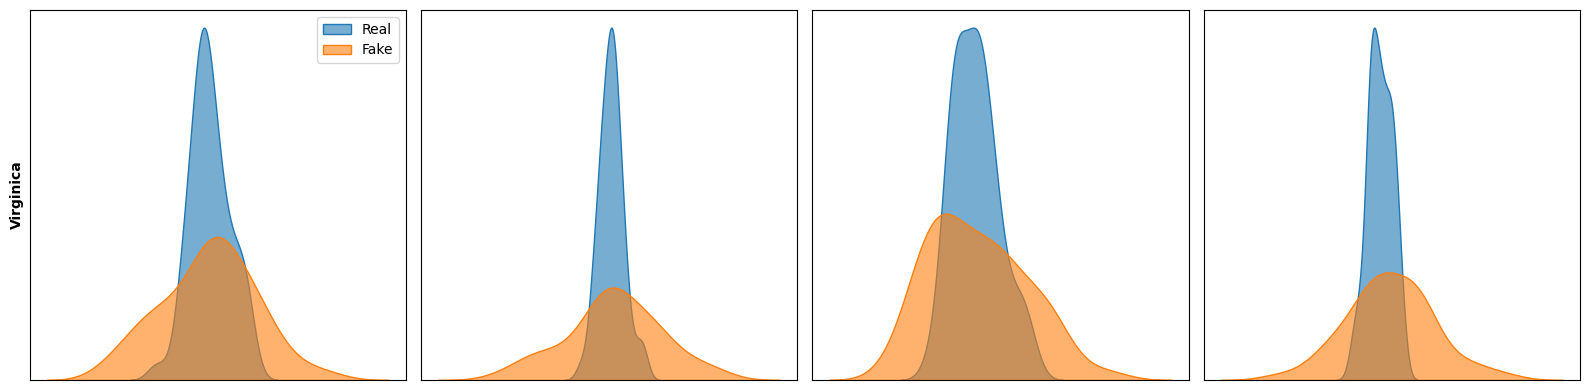

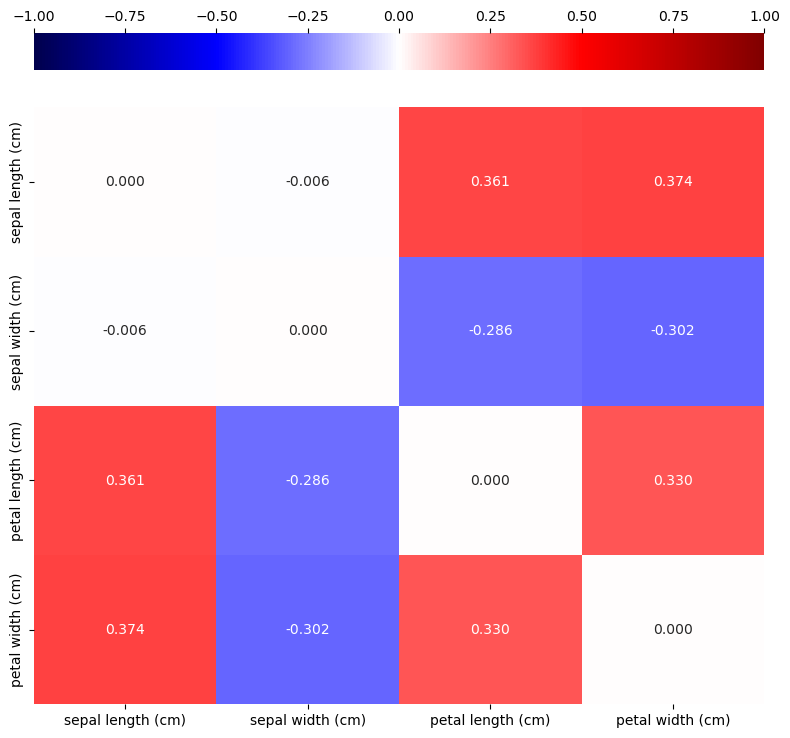

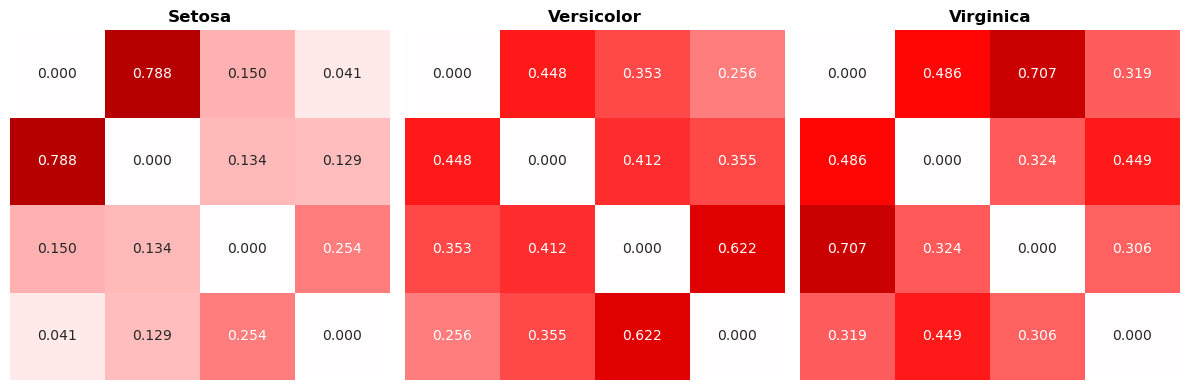

In [10]:
utils.plot_data(real_iris, 'target', df)

Throughout the work, the goal will be to minimize the differences, numerical and graphical, between the actual and synthetic data. The next section will explore which architecture, given equal simplicity, is best for the objective.

## GAN vs VAE